# Analysis of ensembles

In [75]:
import pandas
import matplotlib.pyplot as plt
import geopandas

Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


In [76]:
gdf = geopandas.read_file("../shapefiles/chicago_precincts_economic.shp")

In [2]:
def analysis(data):
    first_plan = data[data["step"] == 0]
    ideal = first_plan["TOTPOP"].sum() / len(first_plan)
    deviation = abs(data["TOTPOP"] - ideal) / ideal
    print("Min. max. population deviation:", deviation.groupby(data["step"]).max().min())

In [3]:
def majority_black_wards(data):
    number_majority_black = (data["NH_BLACK"] / data["TOTPOP"] > 0.5).groupby(data["step"]).sum()
    return number_majority_black

In [59]:
def segregated(data):
    groups = ["NH_BLACK", "NH_WHITE", "NH_ASIAN", "HISP"]
    return data[groups].apply(lambda x: (x / data["TOTPOP"]) > 0.5).any(axis=1)

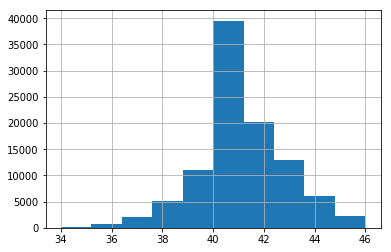

In [62]:
segregated(df).groupby(df["step"]).sum().hist()

In [4]:
def compactness(plans):
    return plans["cut_edges"].min()

In [30]:
df50x1 = pandas.read_csv("../projection/projection_50x1.csv")
df10x5 = pandas.read_csv("../projection/projection_10x5.csv")
df10x3 = pandas.read_csv("../projection/projection_10x3.csv")
df10x3_CA = pandas.read_csv("../projection/projection_10x3_CA.csv")
df10x5_CA = pandas.read_csv("../projection/projection_10x5_CA.csv")

In [9]:
groups = ['Asian', 'Black', 'Hispanic', 'White']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C5A9822588>,
      dtype=object)

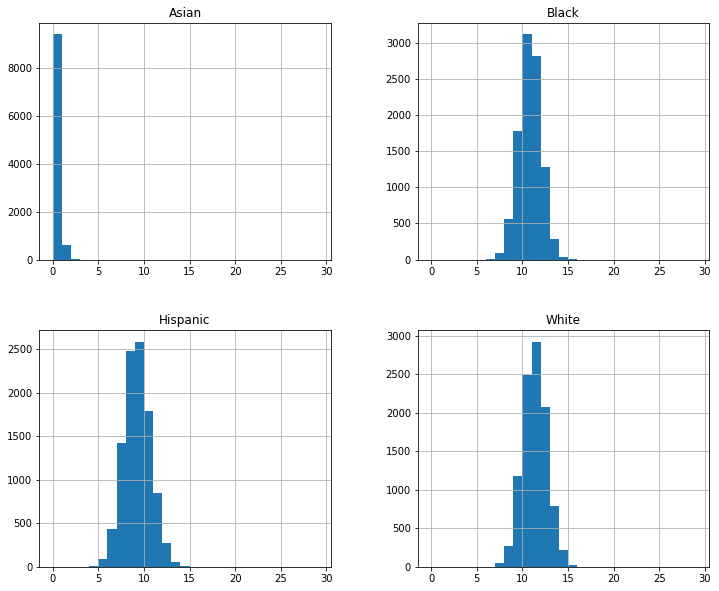

In [31]:
df10x3[groups].hist(figsize=(12,10), bins=list(range(30)))


In [35]:
means = pandas.DataFrame({"50x1": df50x1[groups].mean(), "10x5": df10x5[groups].mean(), "10x3": df10x3[groups].mean(), "10x5_CA": df10x5_CA[groups].mean(), "10x3_CA": df10x3_CA[groups].mean()})

In [37]:
means.to_csv("../means.csv")

In [165]:
df = pandas.read_csv("../ensembles/prec50/results.csv")

In [166]:
first_plan = df[df["step"] == 0]
ideal = first_plan["TOTPOP"].sum() / len(first_plan)
deviation = abs(df["TOTPOP"] - ideal) / ideal

In [167]:
deviation.groupby(df["step"]).max().min()

0.041221472097357735

In [126]:
all_households = df[[ 'LESS_10K', '10K_15K', '15K_20K', '20K_25K', '25K_30K', '30K_35K',
       '35K_40K', '40K_45K', '45K_50K', '50K_60K', '60K_75K', '75K_100K',
       '100K_125K', '125K_150K', '150K_200K', '200K_MORE']].sum(axis=1)

In [153]:
below_20k = df[[ 'LESS_10K', '10K_15K', '15K_20K']].sum(axis=1)

In [128]:
citywide_below20k = first_plan[[ 'LESS_10K', '10K_15K', '15K_20K']].sum().sum() / first_plan[[ 'LESS_10K', '10K_15K', '15K_20K', '20K_25K', '25K_30K', '30K_35K',
       '35K_40K', '40K_45K', '45K_50K', '50K_60K', '60K_75K', '75K_100K',
       '100K_125K', '125K_150K', '150K_200K', '200K_MORE']].sum().sum()

In [140]:
citywide_over200k = first_plan[[ '200K_MORE']].sum().sum() / first_plan[[ 'LESS_10K', '10K_15K', '15K_20K', '20K_25K', '25K_30K', '30K_35K',
       '35K_40K', '40K_45K', '45K_50K', '50K_60K', '60K_75K', '75K_100K',
       '100K_125K', '125K_150K', '150K_200K', '200K_MORE']].sum().sum()

In [78]:
current_plan = gdf.groupby("ward").sum()

In [146]:
above_150k = df[['150K_200K', '200K_MORE']].sum(axis=1)

In [147]:
ensemble_concentrated_wealth = ((above_150k / all_households) > 0.25).groupby(df["step"]).sum()

In [154]:
ensemble_concentrated_poverty = ((below_20k / all_households) > 0.25).groupby(df["step"]).sum()

In [156]:
wealth_or_poverty_ensemble = (((above_150k / all_households) > 0.25) | ((below_20k / all_households) > 0.25)).groupby(df["step"]).sum()

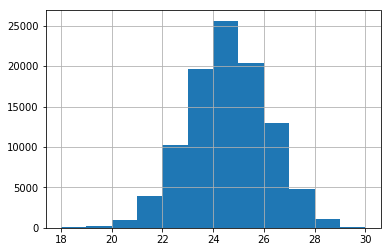

In [161]:
wealth_or_poverty_ensemble.hist(bins=list(range(18,31)))

In [149]:
wealth_current = current_plan[['150K_200K', '200K_MORE']].sum(axis=1) / current_plan[[ 'LESS_10K', '10K_15K', '15K_20K', '20K_25K', '25K_30K', '30K_35K',
       '35K_40K', '40K_45K', '45K_50K', '50K_60K', '60K_75K', '75K_100K',
       '100K_125K', '125K_150K', '150K_200K', '200K_MORE']].sum(axis=1)

In [150]:
(wealth_current > 0.25).sum()

5

In [137]:
extreme_wealth_current = current_plan[['200K_MORE']].sum(axis=1) / current_plan[[ 'LESS_10K', '10K_15K', '15K_20K', '20K_25K', '25K_30K', '30K_35K',
       '35K_40K', '40K_45K', '45K_50K', '50K_60K', '60K_75K', '75K_100K',
       '100K_125K', '125K_150K', '150K_200K', '200K_MORE']].sum(axis=1)

In [139]:
(extreme_wealth_current > 0.25).sum()

0

In [115]:
poverty_current = current_plan[[ 'LESS_10K', '10K_15K', '15K_20K']].sum(axis=1) / current_plan[[ 'LESS_10K', '10K_15K', '15K_20K', '20K_25K', '25K_30K', '30K_35K',
       '35K_40K', '40K_45K', '45K_50K', '50K_60K', '60K_75K', '75K_100K',
       '100K_125K', '125K_150K', '150K_200K', '200K_MORE']].sum(axis=1)

In [131]:
(wealth_current > 0.25).sum()

18

In [101]:
wealth_current

3.41109

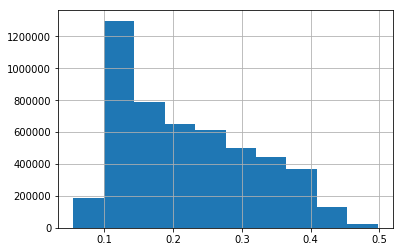

In [74]:
(below_20k / all_households).hist()

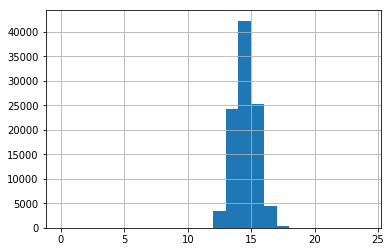

In [55]:
majority_black_wards(df).hist(bins=list(range(25)))

In [19]:
with_seventeen = majority_black_wards(df) == 17

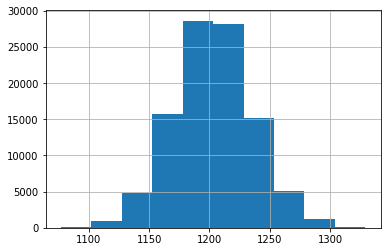

In [27]:
df["cut_edges"].groupby(df["step"]).min()[with_seventeen].hist()

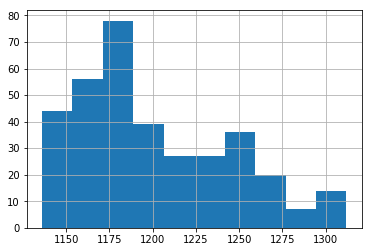

In [28]:
df["cut_edges"].groupby(df["step"]).min()[with_seventeen].hist()

([array([   46.,   969.,  4858., 15723., 28642., 28125., 15155.,  5126.,
          1179.,   177.]),
  array([ 0.,  0., 41., 87., 84., 38., 48., 31., 13.,  6.])],
 array([1077. , 1102.2, 1127.4, 1152.6, 1177.8, 1203. , 1228.2, 1253.4,
        1278.6, 1303.8, 1329. ]),
 <a list of 2 Lists of Patches objects>)

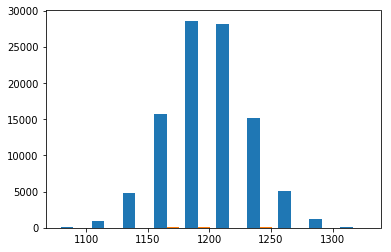

In [31]:
gdf = geopandas.read_file("../shapefiles/chicago_precincts_economic.shp")

In [ ]:
from gerrychain 